<a href="https://colab.research.google.com/github/amaye15/CanineNet/blob/main/code/ModelFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model From Scratch

In [1]:
%pip install mlflow datasets==2.15.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
# os.environ['MLFLOW_TRACKING_USERNAME'] = "andrewmayes14"
# os.environ['MLFLOW_TRACKING_PASSWORD'] = "ccb096afadd26486a787461f3495219662998c4b"
# os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "mlflow"

# mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME']
#                         + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

# # Set the experiment by name
# mlflow.set_experiment("CanineNet")
# mlflow.start_run()
# mlflow.end_run()

In [2]:
import io
import cv2
import datasets
import torch


from PIL import Image
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import pyarrow_hotfix

from functools import partial


pyarrow_hotfix.uninstall()

DATASET = "Alanox/stanford-dogs"

REMOVE_COLS_V1 = ["name", "annotations"]
REMOVE_COLS_V2 = ["name", "annotations", "image"]

NAME_COLS = {"index": "label", 0: "count"}

SPLIT = 0.3

IMAGE_SIZE = (256, 256)

# Load the dataset
dataset = datasets.load_dataset(DATASET, split="full").remove_columns(REMOVE_COLS_V1).train_test_split(test_size=SPLIT) #, streaming=True)

target_df = datasets.load_dataset(DATASET, split="full").remove_columns(REMOVE_COLS_V2).to_pandas().value_counts().reset_index().reset_index().rename(columns=NAME_COLS)

def display_random_images(dataset, key = "image", number_of_images=9, image_size=(128, 128), grid_size=(3, 3)):
    """
    Displays a specified number of random images from a Hugging Face dataset in a grid layout.

    Parameters:
    dataset: The dataset to use.
    number_of_images (int): The number of images to display.
    image_size (tuple): The size (width, height) to which each image will be resized.
    grid_size (tuple): The grid size (rows, columns) for displaying the images.
    """

    # Shuffle the dataset
    shuffled_dataset = dataset.shuffle(seed=np.random.randint(0, 1000))

    # Determine the number of rows and columns in the grid
    rows, cols = grid_size

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, ax in enumerate(axes):
        if i < number_of_images:
            # Decode and resize the image
            image_data = shuffled_dataset[i][key]
            image = image_data
            image = image.resize(image_size)

            # Display the image
            ax.imshow(image)
            ax.axis('off')
        else:
            # Hide extra subplots if the number of images is less than grid cells
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def transforms(examples, transformation_function, to_tensor, target_mapping = None):
    if to_tensor:
      examples["image"] = [v2.functional.pil_to_tensor(transformation_function(image.convert("RGB"))) for image in examples["image"]]
      examples["target"] = [target_mapping[target] for target in examples["target"]]

    else:
      examples["image"] = [transformation_function(image.convert("RGB")) for image in examples["image"]]
    return examples

#display_random_images(dataset)

Generating full split: 0 examples [00:00, ? examples/s]

# Random Transformations

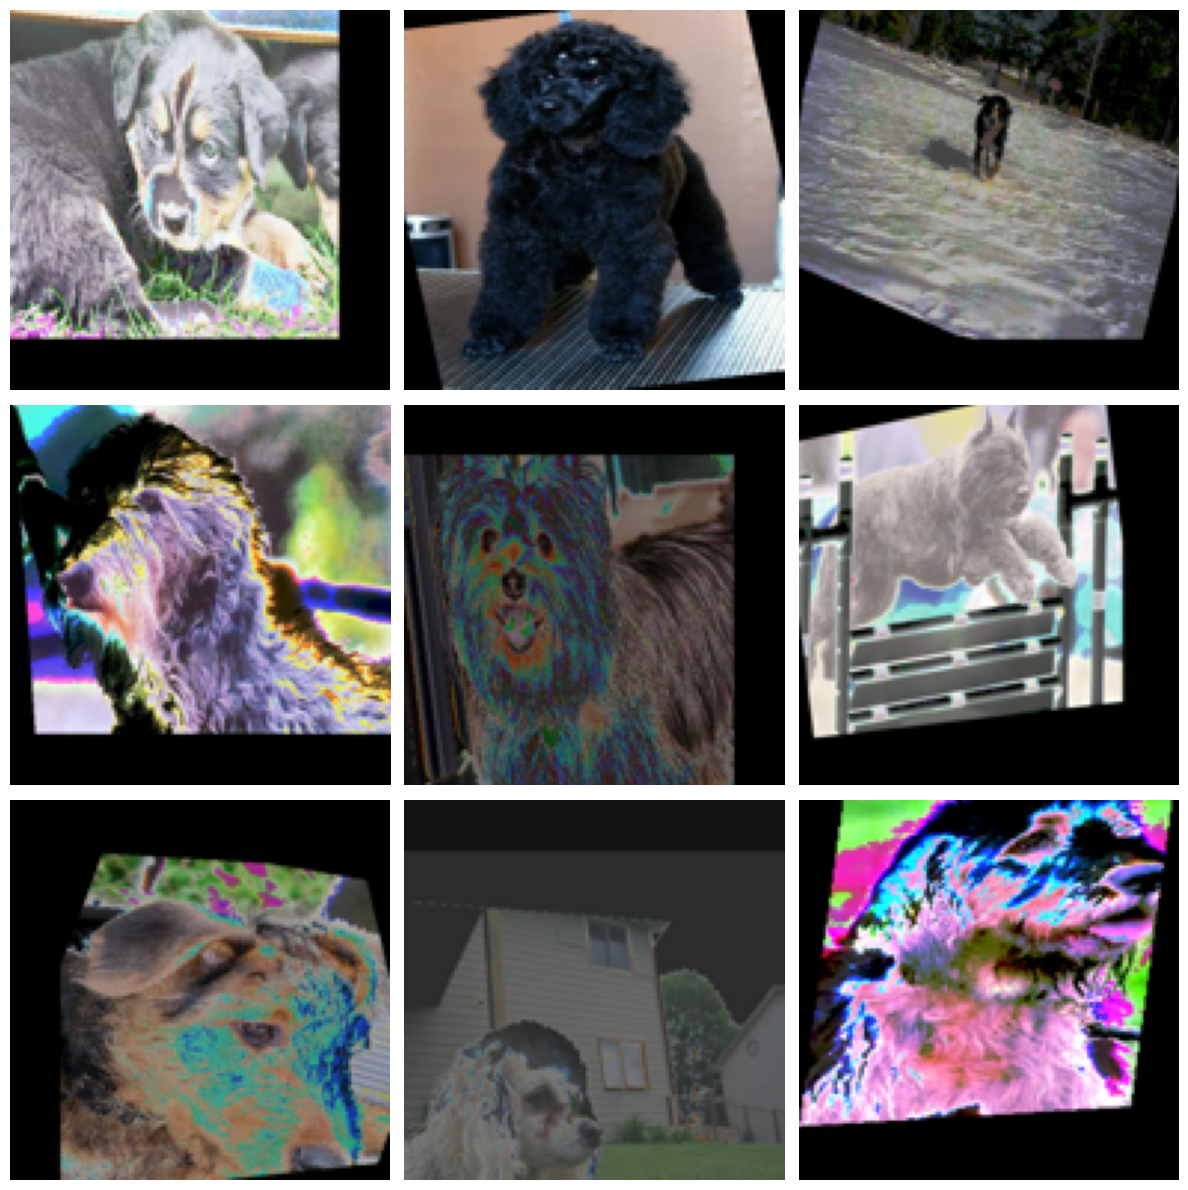

In [3]:
transformation = v2.Compose([v2.RandAugment(num_ops = 10), v2.Resize(size = IMAGE_SIZE)])
dataset.set_transform(partial(transforms, transformation_function = transformation, to_tensor = False))
display_random_images(dataset["train"], key = "image")

# Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, conv_layers, fc_layers, input_size, dropout_rates=None, activation_fn=F.relu, pool_fn=nn.MaxPool2d(kernel_size=2, stride=2)):
        super(CNN, self).__init__()
        self.activation_fn = activation_fn
        self.pool_fn = pool_fn

        self.conv_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        last_channels = input_size[0]
        output_size = input_size[1:]

        for i, (in_channels, out_channels, kernel_size, padding) in enumerate(conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
            output_size = [((size + 2 * padding - (kernel_size - 1) - 1) // 2) + 1 for size in output_size]  # Calculate output size
            last_channels = out_channels
            if dropout_rates and i < len(dropout_rates):
                self.dropouts.append(nn.Dropout(dropout_rates[i]))
            else:
                self.dropouts.append(nn.Identity())  # No dropout

        flatten_size = last_channels * output_size[0] * output_size[1]
        self.fc_layers = nn.ModuleList()
        for out_features in fc_layers:
            self.fc_layers.append(nn.Linear(flatten_size, out_features))
            flatten_size = out_features

    def forward(self, x):
        for conv, dropout in zip(self.conv_layers, self.dropouts):
            x = dropout(self.pool_fn(self.activation_fn(conv(x))))

        x = x.view(x.size(0), -1)  # Flatten

        for i, fc in enumerate(self.fc_layers):
            x = self.activation_fn(fc(x))
            if i < len(self.fc_layers) - 1:
                x = self.dropouts[i](x)  # Apply corresponding dropout

        return x

# Example usage
# model = CNN(
#     conv_layers=[(3, 32, 3, 1), (32, 64, 3, 1), (64, 32, 3, 1), (32, 16, 3, 1)],
#     fc_layers=[128, target_df.shape[0]],
#     input_size=(3, 256, 256),  # Assuming input size of 224x224 with 3 channels
#     dropout_rates=[0.25, 0.25, 0.5]
# )

#output = model(torch.randn(32, 3, 256, 256))  # Example input tensor



In [ ]:
# Model Config
convLayers = [(3, 32, 3, 1), (32, 64, 3, 1), (64, 32, 3, 1), (32, 16, 3, 1)]
fcLayers = [128, target_df.shape[0]]
imageSize = (3, 256, 256)
dpRates = [0.25, 0.25, 0.5]

# Model
model = CNN(conv_layers = convLayers, fc_layers = fcLayers, input_size = imageSize, dropout_rates = dpRates)

# Criteria & Optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train Config
EPOCHS = 100
BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
image_size = (256, 256)
OPS = 10

model.to(DEVICE)

for epoch in range(EPOCHS):
  transformation = v2.Compose([v2.RandAugment(num_ops = OPS), v2.Resize(size = image_size)])

  dataset.set_transform(partial(transforms,
                                transformation_function = transformation,
                                to_tensor = True,
                                target_mapping = dict(zip(target_df["target"].to_dict().values(),
                                                          target_df["target"].to_dict().keys()))))
  # Train
  model.train()
  for batch in DataLoader(dataset["train"], batch_size = BATCH_SIZE, shuffle = True):
    optimizer.zero_grad()

    output = model(batch["image"].float().to(DEVICE))

    loss = criterion(output, batch["target"].to(DEVICE))
    print("Train loss: ", loss)

  # Test
  model.eval()
  with torch.no_grad():
    for batch in DataLoader(dataset["test"], batch_size = BATCH_SIZE, shuffle = False):
      optimizer.zero_grad()

      output = model(batch["image"].float().to(DEVICE))

      loss = criterion(output, batch["target"].to(DEVICE))
      print("Test loss: ", loss)



Train loss:  tensor(10.2659, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(10.5134, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(9.8440, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(10.3496, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(10.0931, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(9.5192, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(10.1989, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(9.8427, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(10.0680, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(9.9249, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(10.0971, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(9.8312, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(10.2229, device='cuda:0', grad_fn=<NllLossBackward0>)
Train loss:  tensor(10.3468, device='cuda:0